In [1]:
from DS_healpix_fragmentation import *
from DS_data_transformation import *
import numpy as np
import healpy as hp
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import pyplot as plt
from skimage.filters import gaussian
from skimage.draw import circle
import pandas as pd
from astropy.table import Table
from tqdm.notebook import tqdm
from threading import Thread
import os

In [2]:
desi_lis_data = pd.read_csv('/home/rt2122/Data/coma_sweep/south/circle_2degree_filtered.csv')
desi_lis_data.head()

,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,EBV,...,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,MASKBITS,phot_is_star_gaia
0,8000,483713,1944p275,0,DEV,194.370715,27.376434,7.766236e+10,5.132580e+10,0.010509,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,8000,483713,1944p275,1,PSF,194.375536,27.377389,6.551291e+10,5.075641e+10,0.010561,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,4096,0
2,8000,483713,1944p275,3,REX,194.377318,27.377674,8.259466e+09,7.358640e+09,0.010576,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,8000,483713,1944p275,4,REX,194.368014,27.376374,1.218444e+10,1.040580e+10,0.010495,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,8000,483713,1944p275,5,PSF,194.376378,27.378784,1.483136e+09,1.303248e+09,0.010614,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [3]:
matr = np.load('/home/rt2122/Data/coma_sweep/south/small_matr.npy')

In [4]:
mdict = matr2dict(matr)

In [5]:
small_nside = 2**15
small_nside

32768

In [6]:
desi_lis_data['FLUX_G'].max(), desi_lis_data['FLUX_R'].max(), desi_lis_data['FLUX_Z'].max()

(12616.448, 28669.667999999998, 53922.125)

In [29]:
def draw_df(arr, ra, dec, channel, mdict, nside, mode='dots', coef=0.1):
    pix = radec2pix(np.array(ra), np.array(dec), nside)
    if mode == 'dots':
        for i in tqdm(range(pix.shape[0])):
            p = pix[i]
            if p in mdict:
                arr[mdict[p]] = max(arr[mdict[p]], 
                                    channel[i])
    else:
        coef = min(arr.shape) * coef / max(channel) 
        for i in tqdm(range(pix.shape[0])):
            p = pix[i]
            if p in mdict:
                coords = circle(*mdict[p], channel[i] * coef, shape=arr.shape)
                arr[coords] += 1
                

In [30]:
#del(desi_lis_pic)
desi_lis_pic = np.zeros(list(matr.shape) + [3])

In [32]:
draw_df(desi_lis_pic_g[:,:,0], desi_lis_data['RA'], desi_lis_data['DEC'], 
        desi_lis_data['FLUX_G'], mdict, small_nside)

In [8]:
brightest_desi_lis = n_max_flux_df(desi_lis_data, 100, ['FLUX_G', 'FLUX_R', 'FLUX_Z'])

In [9]:
brightest_desi_lis.index = np.arange(brightest_desi_lis.shape[0])

In [33]:
desi_lis_pic = np.zeros(list(matr.shape) + [3])
draw_df(desi_lis_pic[:,:,0], brightest_desi_lis['RA'], brightest_desi_lis['DEC'],
       brightest_desi_lis['FLUX_G'], mdict, small_nside, mode='circle', coef=0.04)
draw_df(desi_lis_pic[:,:,1], brightest_desi_lis['RA'], brightest_desi_lis['DEC'],
       brightest_desi_lis['FLUX_R'], mdict, small_nside, mode='circle', coef=0.04)
draw_df(desi_lis_pic[:,:,2], brightest_desi_lis['RA'], brightest_desi_lis['DEC'],
       brightest_desi_lis['FLUX_Z'], mdict, small_nside, mode='circle', coef=0.04)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


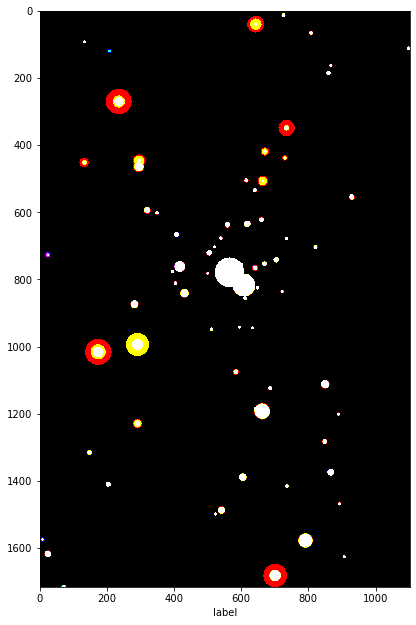

In [34]:
show_pic(desi_lis_pic)

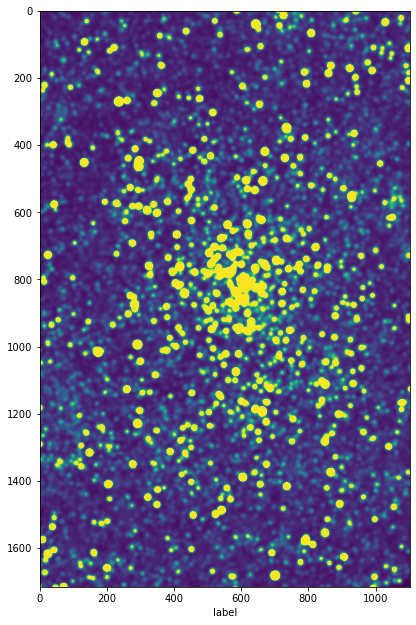

In [37]:
desi_lis_pic_g[:,:,2] = gaussian(desi_lis_pic_g[:,:,0], 5)
show_pic(desi_lis_pic_g[:,:,2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


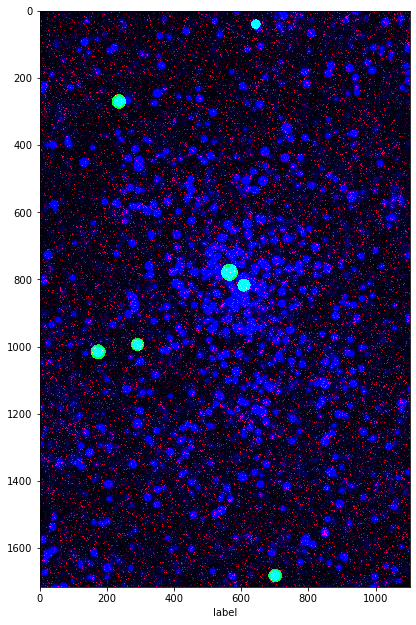

In [82]:
show_pic(desi_lis_pic_g)

In [78]:
#desi_lis_pic_r = np.zeros(list(matr.shape) + [3])
#brightest_desi_lis = n_max_flux_df(desi_lis_data, 5, 'FLUX_R')
#brightest_desi_lis.index = np.arange(brightest_desi_lis.shape[0])
#draw_df(desi_lis_pic_r[:,:,0], desi_lis_data['RA'], desi_lis_data['DEC'], 
#        desi_lis_data['FLUX_R'], mdict, small_nside)
draw_df(desi_lis_pic_r[:,:,1], brightest_desi_lis['RA'], brightest_desi_lis['DEC'],
       brightest_desi_lis['FLUX_R'], mdict, small_nside, mode='circle', rad=500)
#desi_lis_pic_r[:,:,2] = gaussian(desi_lis_pic_r[:,:,0], 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


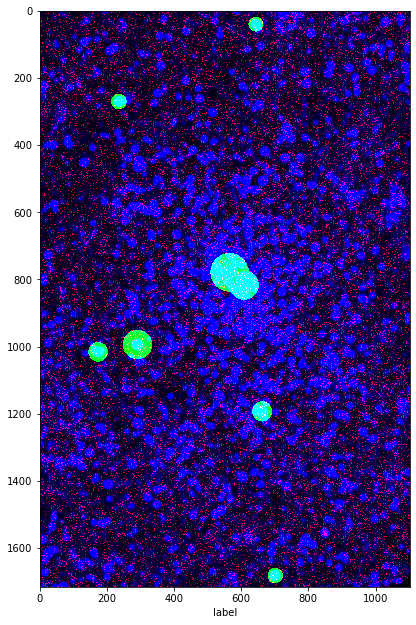

In [79]:
show_pic(desi_lis_pic_r)

In [80]:
#desi_lis_pic_z = np.zeros(list(matr.shape) + [3])
#brightest_desi_lis = n_max_flux_df(desi_lis_data, 5, 'FLUX_R')
#brightest_desi_lis.index = np.arange(brightest_desi_lis.shape[0])
#draw_df(desi_lis_pic_z[:,:,0], desi_lis_data['RA'], desi_lis_data['DEC'], 
#        desi_lis_data['FLUX_R'], mdict, small_nside)
draw_df(desi_lis_pic_z[:,:,1], brightest_desi_lis['RA'], brightest_desi_lis['DEC'],
       brightest_desi_lis['FLUX_R'], mdict, small_nside, mode='circle', rad=500)
#desi_lis_pic_z[:,:,2] = gaussian(desi_lis_pic_z[:,:,0], 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


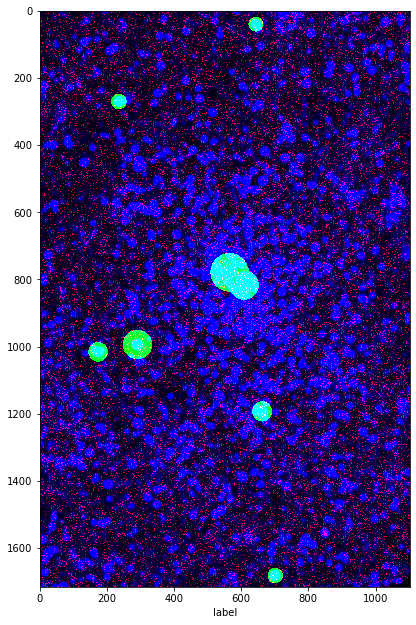

In [81]:
show_pic(desi_lis_pic_z)

In [84]:
desi_lis_pic = np.stack([desi_lis_pic_g, desi_lis_pic_r, desi_lis_pic_z], axis=3)
desi_lis_pic.shape

(1716, 1102, 3, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


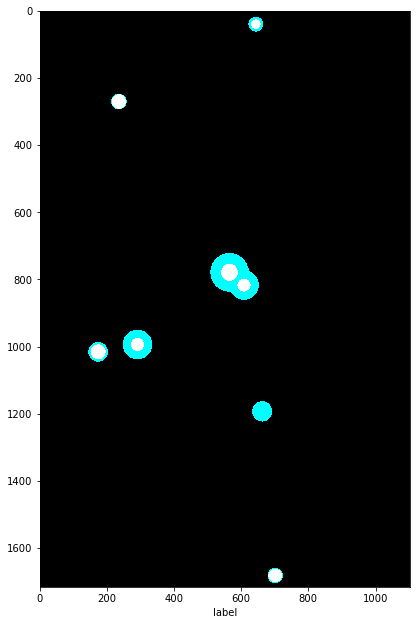

In [85]:
show_pic(desi_lis_pic[:,:,1,:])

In [63]:
pics = [fits.PrimaryHDU([])]
for i in range(3):
    for j in range(3):
        pics.append(fits.ImageHDU(desi_lis_pic[:,:,i,j]))

In [86]:
hdul = fits.HDUList([fits.PrimaryHDU(), 
                     fits.ImageHDU(np.swapaxes(desi_lis_pic_g, 2, 0))])
hdul.writeto('/home/rt2122/Data/coma_sweep/south/g_dot_circle_gauss.fits', overwrite=True)

In [69]:
os.remove('/home/rt2122/Data/coma_sweep/south/grz_dot_circle_gauss.fits')

In [87]:
hdul = fits.HDUList([fits.PrimaryHDU(), 
                     fits.ImageHDU(np.swapaxes(desi_lis_pic_r, 2, 0))])
hdul.writeto('/home/rt2122/Data/coma_sweep/south/r_dot_circle_gauss.fits', overwrite=True)

In [88]:
hdul = fits.HDUList([fits.PrimaryHDU(), 
                     fits.ImageHDU(np.swapaxes(desi_lis_pic_z, 2, 0))])
hdul.writeto('/home/rt2122/Data/coma_sweep/south/z_dot_circle_gauss.fits', overwrite=True)